# Capstone Project - The Battle of Neighborhoods

In [1]:
import folium # map rendering library
import geocoder # import geocoder
import pandas as pd
import numpy as np
import requests # library to handle requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
wiki_coord = pd.read_csv("wiki_coord.csv")

Let's start by creting a map of ou neighborhoods

Using the coordiantes in the data set let's make a map indicating the locatio of all neighberhoods

In [3]:
# create map using latitude and longitude values
map_wiki = folium.Map(location=[wiki_coord['latitude'].iloc[50], wiki_coord['longitude'].iloc[50]],zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(wiki_coord['latitude'], wiki_coord['longitude'], wiki_coord['Borough'], wiki_coord['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wiki)  
    
map_wiki

In [4]:
wiki_coord.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...,43.625490,-79.526000
1,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.632798,-79.493017
2,M7Y,East Toronto,Business reply mail Processing CentrE,43.648700,-79.385450
3,M4Y,Downtown Toronto,Church and Wellesley,43.666659,-79.381472
4,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653340,-79.509766


getNearbyVenues will be function to collect venues information of a given neighborhood

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            'P1NLVQZVKMATOQZBPZYDKCGKXUXIUIFUKUDIUTEP0HA42GUW', 
            'PNP0LXC4CKO2OMZZUZKIH5TF34D4EVXC1VO5324DFN0AH5AF', 
            '20200420', 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's use the funnction to collect the data we need

In [6]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Toronto_venues = getNearbyVenues(names=wiki_coord['Neighborhood'],
                                   latitudes=wiki_coord['latitude'],
                                   longitudes=wiki_coord['longitude']
                                  )



Mimico NW / The Queensway West / South of Bloor / Kingsway Park South West / Royal York South West
Old Mill South / King's Mill Park / Sunnylea / Humber Bay / Mimico NE / The Queensway East / Royal York South East / Kingsway Park South East
Business reply mail Processing CentrE
Church and Wellesley
The Kingsway / Montgomery Road  / Old Mill North
First Canadian Place / Underground city
St. James Town / Cabbagetown
Upper Rouge
Northwest
Alderwood / Long Branch
Stn A PO Boxes
Rosedale
Steeles West / L'Amoreaux West
South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens
New Toronto / Mimico South / Humber Bay Shores
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Kensington Market / Chinatown / Grange Park
Moore Park / Summerhill East
C

A little bit of data wrangling to get everything in place

In [23]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
TOP_10_VENUES = Toronto_venues['Venue Category'].value_counts()[:10].index.values

In [48]:
Toronto_venues2 = Toronto_venues[Toronto_venues['Venue Category'].isin(TOP_10_VENUES)]

In [51]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Café,Clothing Store,Coffee Shop,Hotel,Italian Restaurant,Japanese Restaurant,Park,Pizza Place,Restaurant,Sandwich Place
10,Mimico NW / The Queensway West / South of Bloo...,0,0,1,0,0,0,0,0,0,0
15,Old Mill South / King's Mill Park / Sunnylea /...,0,0,0,0,0,0,1,0,0,0
20,Business reply mail Processing CentrE,0,0,0,1,0,0,0,0,0,0
22,Business reply mail Processing CentrE,0,0,0,0,0,0,0,0,1,0
24,Business reply mail Processing CentrE,0,0,0,0,0,0,0,1,0,0


In [52]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Café,Clothing Store,Coffee Shop,Hotel,Italian Restaurant,Japanese Restaurant,Park,Pizza Place,Restaurant,Sandwich Place
0,Alderwood / Long Branch,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333
1,Bathurst Manor / Wilson Heights / Downsview North,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000
2,Bedford Park / Lawrence Manor East,0.111111,0.000000,0.222222,0.000000,0.222222,0.000000,0.000000,0.111111,0.111111,0.222222
3,Berczy Park,0.117647,0.058824,0.352941,0.117647,0.117647,0.058824,0.058824,0.000000,0.117647,0.000000
4,Birch Cliff / Cliffside West,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
75,Willowdale / Newtonbrook,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
76,Woburn,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
77,Woodbine Heights,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
78,York Mills / Silver Hills,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333


let's get our neighborhood into 3 clusters 

In [53]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [54]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood / Long Branch----
            venue  freq
0     Coffee Shop  0.33
1     Pizza Place  0.33
2  Sandwich Place  0.33
3            Café  0.00
4  Clothing Store  0.00


----Bathurst Manor / Wilson Heights / Downsview North----
            venue  freq
0     Coffee Shop   0.4
1     Pizza Place   0.2
2      Restaurant   0.2
3  Sandwich Place   0.2
4            Café   0.0


----Bedford Park / Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.22
1  Italian Restaurant  0.22
2      Sandwich Place  0.22
3                Café  0.11
4         Pizza Place  0.11


----Berczy Park----
                venue  freq
0         Coffee Shop  0.35
1                Café  0.12
2               Hotel  0.12
3  Italian Restaurant  0.12
4          Restaurant  0.12


----Birch Cliff / Cliffside West----
                 venue  freq
0  Japanese Restaurant   0.5
1          Pizza Place   0.5
2                 Café   0.0
3       Clothing Store   0.0
4          Coffee Shop   0.0


--

4           Hotel  0.00


----York Mills / Silver Hills----
            venue  freq
0     Coffee Shop  0.67
1  Sandwich Place  0.33
2            Café  0.00
3  Clothing Store  0.00
4           Hotel  0.00


----York Mills West----
            venue  freq
0            Park   1.0
1            Café   0.0
2  Clothing Store   0.0
3     Coffee Shop   0.0
4           Hotel   0.0




In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alderwood / Long Branch,Sandwich Place,Pizza Place,Coffee Shop,Restaurant,Park
1,Bathurst Manor / Wilson Heights / Downsview North,Coffee Shop,Sandwich Place,Restaurant,Pizza Place,Park
2,Bedford Park / Lawrence Manor East,Sandwich Place,Italian Restaurant,Coffee Shop,Restaurant,Pizza Place
3,Berczy Park,Coffee Shop,Restaurant,Italian Restaurant,Hotel,Café
4,Birch Cliff / Cliffside West,Pizza Place,Japanese Restaurant,Sandwich Place,Restaurant,Park


In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = wiki_coord

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...,43.625490,-79.526000,2.0,Coffee Shop,Sandwich Place,Restaurant,Pizza Place,Park
1,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.632798,-79.493017,1.0,Park,Sandwich Place,Restaurant,Pizza Place,Japanese Restaurant
2,M7Y,East Toronto,Business reply mail Processing CentrE,43.648700,-79.385450,0.0,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant
3,M4Y,Downtown Toronto,Church and Wellesley,43.666659,-79.381472,0.0,Coffee Shop,Japanese Restaurant,Restaurant,Hotel,Café
4,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653340,-79.509766,1.0,Park,Sandwich Place,Restaurant,Pizza Place,Japanese Restaurant


In [58]:
Toronto_merged.dropna(inplace = True)

And now for the map with our clusters

In [59]:
# create map
map_clusters = folium.Map(location=[wiki_coord['latitude'].iloc[50], wiki_coord['longitude'].iloc[50]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['latitude'], Toronto_merged['longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
Toronto_venues3 = Toronto_venues2.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_venues3.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Mimico NW / The Queensway West / South of Bloo...,43.625490,-79.526000,Tim Hortons,43.626530,-79.528543,Coffee Shop,2,Coffee Shop,Sandwich Place,Restaurant,Pizza Place,Park
15,Old Mill South / King's Mill Park / Sunnylea /...,43.632798,-79.493017,Jeff Healey Park,43.630397,-79.495214,Park,1,Park,Sandwich Place,Restaurant,Pizza Place,Japanese Restaurant
20,Business reply mail Processing CentrE,43.648700,-79.385450,Shangri-La Toronto,43.649129,-79.386557,Hotel,0,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant
22,Business reply mail Processing CentrE,43.648700,-79.385450,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant,0,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant
24,Business reply mail Processing CentrE,43.648700,-79.385450,Pizzeria Libretto,43.648334,-79.385111,Pizza Place,0,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant


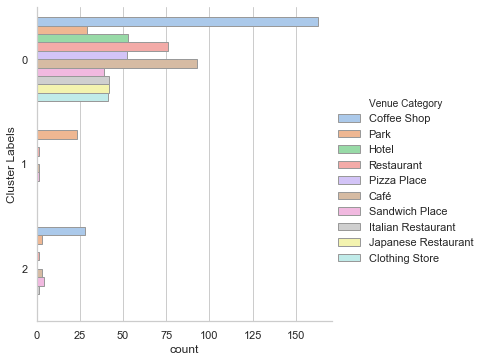

In [67]:
import seaborn as sns
sns.set(style="whitegrid")

sns.catplot(y="Cluster Labels", hue="Venue Category", kind="count",
            palette="pastel", edgecolor=".6",
            data=Toronto_venues3)

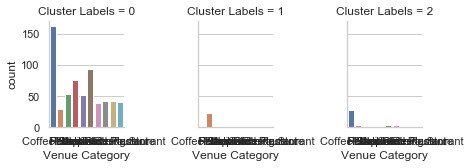

In [70]:
g = sns.catplot("Venue Category", col="Cluster Labels", col_wrap=4,
                data=Toronto_venues3,
                kind="count", height=2.5, aspect=.8)